In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
from genetic_algorithm import run

ModuleNotFoundError: No module named 'genetic_algorithm'

**Select parameters:**

In [3]:
ITERATIONS = 20
GENERATIONS = 4000

**Nelder-Mead Algorithm**

In [4]:
def to_param(config):
    return (
        round(config[0]),
        round(config[1]),
        round(config[2]),
        round(config[3]),
        round(config[4]),
        config[5],
        config[6],
        config[7],
        config[8],
        config[9])

def random_config():
    pop = random.randint(5, 20)
    return np.array([pop,                           # population_size
                     random.randint(2, pop),        # survivor_size
                     GENERATIONS,                   # generations
                     random.randint(0, 3),          # hidden_layers
                     random.randint(5, 50),         # hidden_layer_width
                     random.uniform(0.0, 1.0),      # mutation_rate_matrix
                     random.uniform(0.0, 1.0),      # mutation_rate_bias
                     random.uniform(0.0, 1.0),      # mutation_rate_activation_function
                     random.uniform(0.0, 1.0),      # crossover_rate
                     random.uniform(0.1, 2)])       # gaussian_noise_stdd

def assert_bounds(config):
    population = max(2, config[0])
    survivors = max(2, min(population - 1, config[1]))
    generations = config[2]
    hidden_layers = max(0, config[3])
    hidden_layer_width = max(1, config[4])
    mutation_rate_matrix = max(0, min(1, config[5]))
    mutation_rate_bias = max(0, min(1, config[6]))
    mutation_rate_activation_function = max(0, min(1, config[7]))
    crossover_rate = max(0, min(1, config[8]))
    gaussian_noise_stdd = max(0, config[9])

    return np.array([population,
                     survivors,
                     generations,
                     hidden_layers,
                     hidden_layer_width,
                     mutation_rate_matrix,
                     mutation_rate_bias,
                     mutation_rate_activation_function,
                     crossover_rate,
                     gaussian_noise_stdd])

def nelder_mead(iterations):
    history_max = []    # max scores in each generation (for plot)
    history_avg = []    # average scores in each generation (for plot)

    configs = np.zeros((10, 9))
    scores = np.zeros(9)

    print("start")

    # Random initial vertices
    for i in range(9):
        try:
            config = random_config()
            score = run(*to_param(config))
            print("run: ", i, " random ", score, to_param(config))
            configs[:, i] = config
            scores[i] = score

            # for plot
            history_max.append(max(scores))
            history_avg.append(np.mean(scores))
        except ValueError as error:
            print('VALUE_ERROR:', str(error))
            print(to_param(config))

    # Algorithm
    for i in range(9, iterations + 9):
        idx = scores.argsort()
        worst_idx = idx[0]
        worst_score = scores[worst_idx]
        worst_config = configs[:, worst_idx]

        centeroid = (np.sum(configs, axis=1) - worst_config) / 8
        diff = centeroid - worst_config

        try:
            reflected_config = assert_bounds(centeroid + diff)
            reflected_score = run(*to_param(reflected_config))
        except ValueError as error:
            print(str(error))
            print(to_param(reflected_config))

        #print("run: ", i, worst_idx)

        if reflected_score > scores[idx[8]]:
            #print("expand?")
            expanded_config = assert_bounds(centeroid + 2 * diff)
            expanded_score = run(*to_param(expanded_config))
            if expanded_score > reflected_score:
                configs[:, worst_idx] = expanded_config
                scores[worst_idx] = expanded_score
                #print("expanded_step", expanded_score, to_param(expanded_config))
                print('run: {} {} - max: {} {}'.format(i, 'expansion', max(scores), to_param(expanded_config)))

                # for plot
                history_max.append(max(scores))
                history_avg.append(np.mean(scores))
                continue

        if reflected_score > scores[idx[1]]:
            configs[:, worst_idx] = reflected_config
            scores[worst_idx] = reflected_score
            #print("normal_step", reflected_score, to_param(reflected_config))
            print('run: {} {} - max: {} {}'.format(i, 'reflection', max(scores), to_param(reflected_config)))

            # for plot
            history_max.append(max(scores))
            history_avg.append(np.mean(scores))
            continue

        if reflected_score > worst_score:
            contracted_config = assert_bounds(centeroid + 0.5 * diff)
            contracted_score = run(*to_param(contracted_config))
            if contracted_score > reflected_score:
                configs[:, worst_idx] = contracted_config
                scores[worst_idx] = contracted_score
                #print("contracted_step", contracted_score, to_param(contracted_config))
                print('run: {} {} - max: {} {}'.format(i, 'contraction', max(scores), to_param(contracted_config)))

                # for plot
                history_max.append(max(scores))
                history_avg.append(np.mean(scores))
                continue

        intern_config = assert_bounds(centeroid + 0.7 * (worst_config - centeroid))
        intern_score = run(*to_param(intern_config))

        if intern_score > worst_score:
            configs[:, worst_idx] = intern_config
            scores[worst_idx] = intern_score
            #print("intern_step", intern_score, to_param(intern_config))
            print('run: {} {} - max: {} {}'.format(i, 'internal', max(scores), to_param(intern_config)))

            # for plot
            history_max.append(max(scores))
            history_avg.append(np.mean(scores))
            continue

        #print("shrink")
        best_config = np.copy(configs[:, idx[8]])

        for j in range(0, 9):
            configs[:, j] = 0.9 * (configs[:, j] - best_config) + best_config
            scores[j] = run(*to_param(configs[:, j]))
        print('run: {} {} - max: {} {}'.format(i, 'shrinkage', max(scores), to_param(best_config)))

        # for plot
        history_max.append(max(scores))
        history_avg.append(np.mean(scores))


    # Plot
    plt.figure()
    plt.plot(np.arange(len(history_max)), history_max, label='max fitness')
    plt.plot(np.arange(len(history_avg)), history_avg, label='avg fitness', alpha=0.6)
    plt.title('Nelder-mead algorithm')
    plt.xlabel('Iterations')
    plt.ylabel('Network accuracy')
    plt.legend()
    plt.show()

    idx = scores.argsort()
    best_index = idx[-1]
    best_score = scores[best_index]
    best_config = to_param(assert_bounds(configs[:, best_index]))
    print('\n\nBest performing network:')
    print('Accuracy: {}\n'
          'Hidden layers: {}\n'
          'Neurons per layer: {}\n'
          'Population size: {}\n'
          'Survivors: {}\n'
          'Mutation rate matrix: {}\n'
          'Mutation rate bias: {}\n'
          'Mutation rate activation function: {}\n'
          'Crossover rate: {}\n'
          'Gaussian noise stdd: {}\n'.
          format(best_score,
                 best_config[3],
                 best_config[4],
                 best_config[0],
                 best_config[1],
                 best_config[5],
                 best_config[6],
                 best_config[7],
                 best_config[8],
                 best_config[9]))

**Optimization**

start
run:  0  random  0.4792 (6, 3, 4000, 2, 28, 0.7135155390922217, 0.8898218328200824, 0.43653307175519784, 0.09594569562971, 0.35664930595425814)
run:  1  random  0.3943 (9, 5, 4000, 2, 6, 0.8090190445777187, 0.9297542630631912, 0.04195647045138051, 0.38517287568090985, 1.948524724958945)
run:  2  random  0.3266 (18, 18, 4000, 2, 23, 0.034414160513168035, 0.9800504279440665, 0.8685446103573202, 0.08380305350733097, 0.1750853528755696)
run:  3  random  0.7212 (10, 8, 4000, 0, 19, 0.6319696406359923, 0.5229100083087885, 0.654293092183365, 0.4382481080469326, 1.4351585499720236)
run:  4  random  0.6297 (7, 6, 4000, 0, 27, 0.33569529451952285, 0.8370755815257483, 0.46325499439060747, 0.2932386370134613, 0.9463729343213964)
run:  5  random  0.5339 (5, 3, 4000, 1, 7, 0.09245990225369805, 0.76483746097201, 0.7033516794070642, 0.83485092506855, 0.4583998238154612)
run:  6  random  0.7332 (8, 7, 4000, 0, 16, 0.4107863663052639, 0.9332264115555923, 0.020233018781777634, 0.7951527878889337, 1

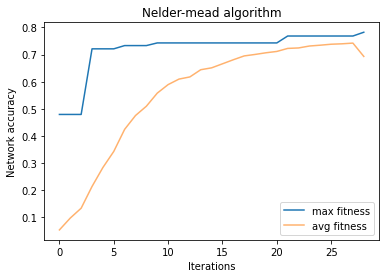



Best performing network:
Accuracy: 0.7824
Hidden layers: 0
Neurons per layer: 34
Population size: 7
Survivors: 6
Mutation rate matrix: 0.8265751487121369
Mutation rate bias: 0.6750654496850161
Mutation rate activation function: 0.0869455304311119
Crossover rate: 0.29385255267515753
Gaussian noise stdd: 1.980572797709365

CPU times: total: 2h 30min 38s
Wall time: 2h 29min 55s


In [5]:
%%time
nelder_mead(ITERATIONS)